In [2]:
import networkx as nx
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# Pipeline

### Data Loader

We need to load networks into memory. Usually networks are organized as pairs of nodes. And sometimes different edges have different weights. Hence, we use networkx.DiGraph to store such structure information and attributes.

In [2]:
def load_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        user_id, friends = row["user_id"], eval(row["friends"])
        for friend in friends:
            # add each friend relation as an edge
            edges.append((user_id, friend))
    edges = sorted(edges)
    
    return edges

def load_test_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    scores = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        edges.append((row["src"], row["dst"]))
        scores.append(row["score"])
    #edges = sorted(edges)
    
    return edges,scores

def generate_false_edges(true_edges, num_false_edges=5):
    """
    generate false edges given true edges
    """
    nodes = list(set(chain.from_iterable(true_edges)))
    N = len(nodes)
    true_edges = set(true_edges)
    print(N, len(true_edges))
    false_edges = set()
    
    while len(false_edges) < num_false_edges:
        # randomly sample two different nodes and check whether the pair exisit or not
        src, dst = nodes[int(np.random.rand() * N)], nodes[int(np.random.rand() * N)]
        if src != dst and (src, dst) not in true_edges and (src, dst) not in false_edges:
            false_edges.add((src, dst))
    false_edges = sorted(false_edges)
    
    return false_edges

def construct_graph_from_edges(edges):
    """
    generate a directed graph object given true edges
    DiGraph documentation: https://networkx.github.io/documentation/stable/reference/classes/digraph.html
    """
    # convert a list of edges {(u, v)} to a list of edges with weights {(u, v, w)}
    edge_weight = defaultdict(float)
    for e in edges:
        edge_weight[e] += 1.0
    weighed_edge_list = list()
    for e in sorted(edge_weight.keys()):
        weighed_edge_list.append((e[0], e[1], edge_weight[e]))
        
    graph = nx.DiGraph()
    graph.add_weighted_edges_from(weighed_edge_list)
    
    print("number of nodes:", graph.number_of_nodes())
    print("number of edges:", graph.number_of_edges())
    
    return graph

### Random Walk Generator

Random walk generators or random walkers yield random walks that contain both local and higher-order neighborhood information. However, naive non-uniform sampling is very slow, which requires O(n) time complexity. Here alias sampling can reduce the time complexity to O(1) with O(n) space. If you are interested, please see the following blog.

In [3]:
def alias_setup(probs):
    """
    compute utility lists for non-uniform sampling from discrete distributions.
    details: https://lips.cs.princeton.edu/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int)

    smaller = list()
    larger = list()
    for kk, prob in enumerate(probs):
        q[kk] = K * prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def get_alias_node(graph, node):
    """
    get the alias node setup lists for a given node.
    """
    # get the unnormalized probabilities with the first-order information
    unnormalized_probs = list()
    for nbr in graph.neighbors(node):
        unnormalized_probs.append(graph[node][nbr]["weight"])
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs
        
    return alias_setup(normalized_probs)
    
def get_alias_edge(graph, src, dst, p=1, q=1):
    """
    get the alias edge setup lists for a given edge.
    """
    # get the unnormalized probabilities with the second-order information
    unnormalized_probs = list()
    for dst_nbr in graph.neighbors(dst):
        if dst_nbr == src: # distance is 0
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/p)
        elif graph.has_edge(dst_nbr, src): # distance is 1
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"])
        else: # distance is 2
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/q)
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs

    return alias_setup(normalized_probs)

def preprocess_transition_probs(graph, p=1, q=1):
    """
    preprocess transition probabilities for guiding the random walks.
    """
    alias_nodes = dict()
    for node in graph.nodes():
        alias_nodes[node] = get_alias_node(graph, node)

    alias_edges = dict()
    for edge in graph.edges():
        alias_edges[edge] = get_alias_edge(graph, edge[0], edge[1], p=p, q=q)

    return alias_nodes, alias_edges

The difference between DeepWalk and node2vec is how to generate random walks. The former only consider the first-order information while the latter also involves the second-order information.

In [4]:
def alias_draw(J, q):
    """
    draw sample from a non-uniform discrete distribution using alias sampling.
    """
    K = len(J)

    kk = int(np.floor(np.random.rand() * K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]


# helper function to generate the long random walk as desired
def fallback(walk, fetch_last_num=1):
    if len(walk) > fetch_last_num:
        walk.pop()
        fetched = []
        for i in range(fetch_last_num):
            fetched.append(walk[-1-i])
        return walk, fetched
    else:
        return [], [None for _ in range(fetch_last_num)]

def generate_first_order_random_walk(graph, alias_nodes, 
                                     walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the first order information.
    max_trials: set the max trials to be one for standard random walk. Larger max_trails will make the generated biased.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    cur = start_node
    num_tried = 0
    
    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0: # if we can sample next nodes
            # sample the next node based on alias_nodes
            cur = cur_nbrs[alias_draw(*alias_nodes[cur])]
            walk.append(cur)
        else: # if we can't do that
            num_tried += 1
            if num_tried >= max_trails:
                break

            walk, fetched = fallback(walk, fetch_last_num=1)
            cur = fetched[0]
            if len(walk) == 0: # if falls back to the empty walk
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
    ########## end ##########

    if verbose: 
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk
    
def generate_second_order_random_walk(graph, alias_nodes, alias_edges, 
                                      walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the second order information.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    
    prev = None
    cur = start_node
    num_tried = 0

    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0:
            if prev is None:
                # sample the next node based on alias_nodes
                prev, cur = cur, cur_nbrs[alias_draw(*alias_nodes[cur])]
            else:
                # sample the next node based on alias_edges
                prev, cur = cur, cur_nbrs[alias_draw(*alias_edges[(prev, cur)])]
            walk.append(cur)
        else:
            num_tried += 1
            if num_tried >= max_trails:
                break
            walk, (cur, prev) = fallback(walk, fetch_last_num=2)
            if len(walk) == 0:
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
                prev = None
    ########## end ##########
    if verbose: 
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk

### Network Embedding Algorithms

In [5]:
def build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10):
    """
    build a deepwalk model
    """
    print("building a DeepWalk model...", end="\n")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_first_order_random_walk(
                graph, alias_nodes, walk_length=walk_length, start_node=node))
        
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    # train a skip-gram model for these walks
    model = Word2Vec(walks, vector_size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), epochs=10)
    print("training time: %.4f" % (time.time()-st))
    
    return model

def build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10):
    """
    build a node2vec model
    """
    print("building a node2vec model...", end="\n")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_second_order_random_walk(
                graph, alias_nodes, alias_edges, walk_length=walk_length, start_node=node))
            
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0    
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    # train a skip-gram model for these walks
    model = Word2Vec(walks, vector_size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), epochs=10)
    print("training time: %.4f" % (time.time()-st))
    
    return model

### Scorer

In [6]:
def get_cosine_sim(model, u, v):
    """
    get the cosine similarity between two nodes
    """
    try:
        u = model.wv[u]
        v = model.wv[v]
        return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    except:
        return 0.5

def get_auc_score(model, true_edges, false_edges):
    """
    get the auc score
    """
    y_true = [1] * len(true_edges) + [0] * len(false_edges)
    
    y_score = list()
    for e in true_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    for e in false_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    
    return roc_auc_score(y_true, y_score)

def get_auc_score_test(model, edges,scores):
    """
    get the auc score
    """
    y_true = scores
    
    y_score = list()
    for e in edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    
    return roc_auc_score(y_true, y_score)


def write_pred(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)
    
    



def write_valid_ans(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)

### Try them over a Real-life Network

Firstly, we need to load edges into memory and use the networkx.DiGraph structure to store the graph.

In [7]:
train_file = "data/train.csv"
valid_file = "data/valid.csv"
test_file = "data/test.csv"

np.random.seed(2023)
train_edges = load_data(train_file)
graph = construct_graph_from_edges(train_edges)
valid_edges = load_data(valid_file)
false_edges = generate_false_edges(train_edges+valid_edges, 40000-len(valid_edges))
test_edges,test_scores = load_test_data(test_file)

number of nodes: 8334
number of edges: 100000
8485 119267


After that, we can use preprocess transition probabilities with the help of alias sampling.

In [8]:
alias_nodes, alias_edges = preprocess_transition_probs(graph, p=1, q=1)

C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


We can use random walk generators to generate random walks.

Let's try to generate a first-order random walk and a second-order random walk.

In [9]:
generate_first_order_random_walk(graph, alias_nodes=alias_nodes,
                                 start_node="N6ZTMIue-2b30CJv2tyPGg", walk_length=10)

['N6ZTMIue-2b30CJv2tyPGg',
 'FaAb-CoKW4xDvLTSPtEbgw',
 'Usvn6LvVXlZFcLWqFS-L5g',
 'iN7T3vQoC3v_MPs2TzH5Zw',
 'MMf0LhEk5tGa1LvN7zcDnA',
 'maK3UBQczh33NuDjBYeHrA',
 'P2sQVHyHmy4WA0I7NI5hWg',
 'PeLGa5vUR8_mcsn-fn42Jg',
 '5adw7kIif2QalymDFucRLg',
 'J9c0XM-wV_KQmtZYxvIFFQ']

In [10]:
generate_second_order_random_walk(graph, alias_nodes=alias_nodes, alias_edges=alias_edges,
                                  start_node="N6ZTMIue-2b30CJv2tyPGg", walk_length=10)

['N6ZTMIue-2b30CJv2tyPGg',
 'WJKocp9RE0KatUwh3_DkGg',
 'gvyYZgFdBbcT3xGjWOvZag',
 'rCWrxuRC8_pfagpchtHp6A',
 'oWjEjoX_L9HeXnD4bKjw2w',
 'rCWrxuRC8_pfagpchtHp6A',
 'hrWLrisXtLPPkOSRPYn2WQ',
 'Lfv4hefW1VbvaC2gatTFWA',
 'ciXjBfJrAEteIKpzZg4I9g',
 'H7JLpACO44A3xVXnOt1Z_A']

And we can build a DeepWalk model and a node2vec model. Here we set p=q=0.5 so that the walker will not go very far away from the start node.

In [11]:
model = build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10)

building a DeepWalk model...
number of walks: 83340	average walk length: 9.9029	training time: 20.9106


In [12]:
model = build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10)

building a node2vec model...
number of walks: 83340	average walk length: 9.9900	training time: 24.4580


Let's see the node embeddings of three nodes, and cosine similarities of two edges.

In [13]:
print("node embedding (\"N6ZTMIue-2b30CJv2tyPGg\"):",
      model.wv["N6ZTMIue-2b30CJv2tyPGg"])
print("node embedding (\"N7E-CfqdME28dakWdEKNvw\"):",
      model.wv["N7E-CfqdME28dakWdEKNvw"])
print("node embedding (\"MmlJSLDg-IFaeXb5wdJbgg\"):",
      model.wv.vectors[model.wv.index_to_key.index("MmlJSLDg-IFaeXb5wdJbgg")])
print("true edge (\"N6ZTMIue-2b30CJv2tyPGg\", \"N7E-CfqdME28dakWdEKNvw\"):",
      get_cosine_sim(model, "N6ZTMIue-2b30CJv2tyPGg", "N7E-CfqdME28dakWdEKNvw"))
print("false edge (\"N6ZTMIue-2b30CJv2tyPGg\", \"MmlJSLDg-IFaeXb5wdJbgg\"):",
      get_cosine_sim(model, "N6ZTMIue-2b30CJv2tyPGg", "MmlJSLDg-IFaeXb5wdJbgg"))

node embedding ("N6ZTMIue-2b30CJv2tyPGg"): [ 1.7828258   1.4567943   0.85132635  0.25543055  1.0486357   1.1253562
  0.52099586  1.4922084  -1.2208858  -0.7225249 ]
node embedding ("N7E-CfqdME28dakWdEKNvw"): [ 1.1044775   0.4856466   0.9143465   0.4032046   1.3851764   0.26724246
  1.3699701   0.5974118  -0.14071926 -0.76233464]
node embedding ("MmlJSLDg-IFaeXb5wdJbgg"): [ 1.5638978  -1.2588761   0.35911077 -2.307611    0.0284093  -0.0771988
  2.7955937  -0.26346782 -1.1695207  -0.61474663]
true edge ("N6ZTMIue-2b30CJv2tyPGg", "N7E-CfqdME28dakWdEKNvw"): 0.7862727
false edge ("N6ZTMIue-2b30CJv2tyPGg", "MmlJSLDg-IFaeXb5wdJbgg"): 0.2253663


# Link Prediction

We can train the model with different parameters and test the model on the validation set. Please show your parameter search process and analysis in your code, and visualization tools (Heatmap, etc.) are recommended to make your analysis clear.

In [34]:
np.random.seed(0)

node_dim = 10 # TODO
num_walks = [5, 10, 20, 40] # TODO
walk_length = [10, 20, 40] # TODO

deepwalk_auc_scores = dict()
for num_walk in num_walks:
    for walk in walk_length:
        print("node dim: %d,\tnum_walks: %d,\twalk_length: %d" % (node_dim, num_walk, walk), end="\n")
        model = build_deepwalk(graph, alias_nodes, 
                         node_dim=node_dim, num_walks=num_walk, walk_length=walk)
        deepwalk_auc_scores[(node_dim, num_walk, walk,'valid')] = get_auc_score(model, valid_edges, false_edges)
        print("valid auc: %.4f" % (deepwalk_auc_scores[(node_dim, num_walk, walk,'valid')]))

node dim: 10,	num_walks: 5,	walk_length: 10
building a DeepWalk model...
number of walks: 41670	average walk length: 9.9018	training time: 18.4714
valid auc: 0.9095
node dim: 10,	num_walks: 5,	walk_length: 20
building a DeepWalk model...
number of walks: 41670	average walk length: 19.7629	training time: 19.4895
valid auc: 0.9262
node dim: 10,	num_walks: 5,	walk_length: 40
building a DeepWalk model...
number of walks: 41670	average walk length: 39.4158	training time: 28.8811
valid auc: 0.9280
node dim: 10,	num_walks: 10,	walk_length: 10
building a DeepWalk model...
number of walks: 83340	average walk length: 9.9029	training time: 24.6963
valid auc: 0.9254
node dim: 10,	num_walks: 10,	walk_length: 20
building a DeepWalk model...
number of walks: 83340	average walk length: 19.7629	training time: 35.9000
valid auc: 0.9311
node dim: 10,	num_walks: 10,	walk_length: 40
building a DeepWalk model...
number of walks: 83340	average walk length: 39.4176	training time: 54.1719
valid auc: 0.9288
nod

Text(0, 0.5, 'num_walks')

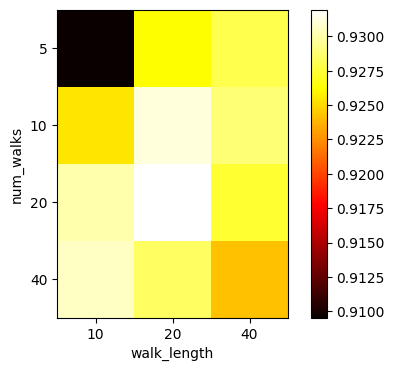

In [41]:
plt.figure(figsize=(6, 4))
node_dim = 10
# you should have an auc score dictionary here.
a = np.array([[deepwalk_auc_scores[(node_dim, num_walks, walk_length,'valid')] for walk_length in [10, 20, 40]] for num_walks in [5, 10, 20, 40]])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2], labels=[10, 20, 40])
plt.xlabel("walk_length")
plt.yticks(ticks=[0,1,2,3], labels=[5, 10, 20, 40])
plt.ylabel("num_walks")

In [41]:
np.random.seed(0)

node_dim = 10 # TODO
num_walks = [15, 20, 25, 30] # TODO
walk_length = [15, 20, 25, 30] # TODO

deepwalk_auc_scores = dict()
for num_walk in num_walks:
    for walk in walk_length:
        print("node dim: %d,\tnum_walks: %d,\twalk_length: %d" % (node_dim, num_walk, walk), end="\n")
        model = build_deepwalk(graph, alias_nodes, 
                         node_dim=node_dim, num_walks=num_walk, walk_length=walk)
        deepwalk_auc_scores[(node_dim, num_walk, walk,'valid')] = get_auc_score(model, valid_edges, false_edges)
        print("valid auc: %.4f" % (deepwalk_auc_scores[(node_dim, num_walk, walk,'valid')]))

node dim: 10,	num_walks: 15,	walk_length: 15
building a DeepWalk model...
number of walks: 125010	average walk length: 14.8360	training time: 51.0686
valid auc: 0.9315
node dim: 10,	num_walks: 15,	walk_length: 20
building a DeepWalk model...
number of walks: 125010	average walk length: 19.7636	training time: 56.6202
valid auc: 0.9313
node dim: 10,	num_walks: 15,	walk_length: 25
building a DeepWalk model...
number of walks: 125010	average walk length: 24.6873	training time: 65.5957
valid auc: 0.9295
node dim: 10,	num_walks: 15,	walk_length: 30
building a DeepWalk model...
number of walks: 125010	average walk length: 29.6029	training time: 70.8716
valid auc: 0.9294
node dim: 10,	num_walks: 20,	walk_length: 15
building a DeepWalk model...
number of walks: 166680	average walk length: 14.8371	training time: 62.5741
valid auc: 0.9318
node dim: 10,	num_walks: 20,	walk_length: 20
building a DeepWalk model...
number of walks: 166680	average walk length: 19.7638	training time: 71.6649
valid auc:

In [58]:
num_walks_values = [15, 20, 25, 30]
walk_length_values = [15, 20, 25, 30]
def corr_heatmap1():
    # Create figure and axes objects
    fig, ax1 = plt.subplots(1, 1, figsize=(13, 4))
    # Create heatmap 1
    a1 = np.array([deepwalk_auc_scores[(node_dim, num_walks, walk_length, 'valid')] for num_walks in num_walks_values for walk_length in walk_length_values])
    a1 = a1.reshape(4, 4)
    im1 = ax1.imshow(a1, cmap="coolwarm", interpolation="nearest")

    # Add colorbars
    cbar1 = ax1.figure.colorbar(im1, ax=ax1)
    cbar1.ax.set_ylabel("AUC score", rotation=-90, va="bottom")

    # Add annotations to heatmap 1
    for i in range(len(num_walks_values)):
        for j in range(len(walk_length_values)):
            text = ax1.text(j, i, "{:.4f}".format(a1[i, j]), ha="center", va="center", color="black")

    # Set axis labels and tick marks for heatmap 1
    ax1.set_yticks(np.arange(len(num_walks_values)))
    ax1.set_xticks(np.arange(len(walk_length_values)))
    ax1.set_yticklabels(num_walks_values)
    ax1.set_xticklabels(walk_length_values)
    ax1.set_xlabel("Walk length")
    ax1.set_ylabel("Number of walks")

    # Rotate tick labels on y-axis
    plt.setp(ax1.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")

    # Show plot
    plt.show()

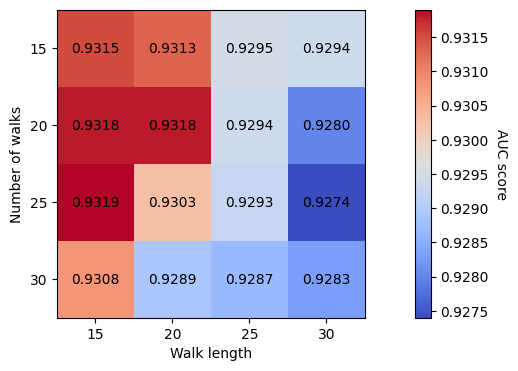

In [59]:
corr_heatmap1()

In [14]:
np.random.seed(0)

node_dim = 10 # TODO
num_walks = [5, 10, 20, 40] # TODO
walk_length = [10, 20, 40] # TODO
p_list = [0.25, 0.5, 0.75] # TODO
q_list = [0.25, 0.5, 0.75] # TODO

node2vec_auc_scores = dict()
for num_walk in num_walks:
    for walk in walk_length:
        for p in p_list:
            for q in q_list:
                print("node dim: %d,\tnum_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (
                    node_dim, num_walk, walk, p, q), end="\n")
                alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
                model = build_node2vec(graph, alias_nodes, alias_edges, 
                        node_dim=node_dim, num_walks=num_walk, walk_length=walk)
                node2vec_auc_scores[(node_dim, num_walk, walk, p, q,'valid')] = get_auc_score(model, valid_edges, false_edges)
                print("valid auc: %.4f" % (node2vec_auc_scores[(node_dim, num_walk, walk, p, q,'valid')]))

node dim: 10,	num_walks: 5,	walk_length: 10,	p: 0.25,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 9.9928	training time: 13.9138
valid auc: 0.9147
node dim: 10,	num_walks: 5,	walk_length: 10,	p: 0.25,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 9.9906	training time: 15.0834
valid auc: 0.9158
node dim: 10,	num_walks: 5,	walk_length: 10,	p: 0.25,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 9.9923	training time: 13.9091
valid auc: 0.9184
node dim: 10,	num_walks: 5,	walk_length: 10,	p: 0.50,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 9.9882	training time: 13.2218
valid auc: 0.9138
node dim: 10,	num_walks: 5,	walk_length: 10,	p: 0.50,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 9.9905	training time: 17.4284
valid auc: 0.9130
node dim: 10,	num_walks: 5,	walk_length: 10,	p: 0.50,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 9.9907	training time: 20.0374
valid auc: 0.9145
node dim: 10,	num_walks: 5,	walk_length: 10,	p: 0.75,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 9.9866	training time: 15.8593
valid auc: 0.9134
node dim: 10,	num_walks: 5,	walk_length: 10,	p: 0.75,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 9.9920	training time: 15.9484
valid auc: 0.9115
node dim: 10,	num_walks: 5,	walk_length: 10,	p: 0.75,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 9.9900	training time: 15.6863
valid auc: 0.9164
node dim: 10,	num_walks: 5,	walk_length: 20,	p: 0.25,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 19.9613	training time: 21.2356
valid auc: 0.9270
node dim: 10,	num_walks: 5,	walk_length: 20,	p: 0.25,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 19.9649	training time: 20.7895
valid auc: 0.9278
node dim: 10,	num_walks: 5,	walk_length: 20,	p: 0.25,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 19.9670	training time: 21.1810
valid auc: 0.9276
node dim: 10,	num_walks: 5,	walk_length: 20,	p: 0.50,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 19.9464	training time: 26.1572
valid auc: 0.9287
node dim: 10,	num_walks: 5,	walk_length: 20,	p: 0.50,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 19.9569	training time: 22.4591
valid auc: 0.9279
node dim: 10,	num_walks: 5,	walk_length: 20,	p: 0.50,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 19.9682	training time: 20.7242
valid auc: 0.9276
node dim: 10,	num_walks: 5,	walk_length: 20,	p: 0.75,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 19.9450	training time: 20.9136
valid auc: 0.9272
node dim: 10,	num_walks: 5,	walk_length: 20,	p: 0.75,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 19.9593	training time: 20.8346
valid auc: 0.9269
node dim: 10,	num_walks: 5,	walk_length: 20,	p: 0.75,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 19.9636	training time: 21.4013
valid auc: 0.9284
node dim: 10,	num_walks: 5,	walk_length: 40,	p: 0.25,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 39.8404	training time: 30.2754
valid auc: 0.9297
node dim: 10,	num_walks: 5,	walk_length: 40,	p: 0.25,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 39.8759	training time: 30.7618
valid auc: 0.9294
node dim: 10,	num_walks: 5,	walk_length: 40,	p: 0.25,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 39.8930	training time: 31.3430
valid auc: 0.9296
node dim: 10,	num_walks: 5,	walk_length: 40,	p: 0.50,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 39.8085	training time: 30.2107
valid auc: 0.9291
node dim: 10,	num_walks: 5,	walk_length: 40,	p: 0.50,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 39.8374	training time: 29.8243
valid auc: 0.9300
node dim: 10,	num_walks: 5,	walk_length: 40,	p: 0.50,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 39.8674	training time: 29.5042
valid auc: 0.9302
node dim: 10,	num_walks: 5,	walk_length: 40,	p: 0.75,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 39.7983	training time: 29.7336
valid auc: 0.9288
node dim: 10,	num_walks: 5,	walk_length: 40,	p: 0.75,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 39.8363	training time: 29.8758
valid auc: 0.9305
node dim: 10,	num_walks: 5,	walk_length: 40,	p: 0.75,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 41670	average walk length: 39.8533	training time: 30.2884
valid auc: 0.9292
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.25,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 9.9913	training time: 28.2297
valid auc: 0.9282
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.25,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 9.9910	training time: 27.3537
valid auc: 0.9275
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.25,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 9.9919	training time: 29.6564
valid auc: 0.9264
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.50,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 9.9883	training time: 28.2238
valid auc: 0.9258
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.50,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 9.9904	training time: 28.0549
valid auc: 0.9273
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.50,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 9.9910	training time: 27.5130
valid auc: 0.9259
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.75,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 9.9865	training time: 28.3126
valid auc: 0.9245
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.75,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 9.9910	training time: 27.9806
valid auc: 0.9262
node dim: 10,	num_walks: 10,	walk_length: 10,	p: 0.75,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 9.9901	training time: 27.6793
valid auc: 0.9288
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.25,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9599	training time: 39.8285
valid auc: 0.9303
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.25,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9671	training time: 37.8491
valid auc: 0.9310
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.25,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9685	training time: 38.5692
valid auc: 0.9306
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.50,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9485	training time: 38.2900
valid auc: 0.9307
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.50,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9600	training time: 41.5660
valid auc: 0.9312
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.50,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9650	training time: 50.6132
valid auc: 0.9305
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.75,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9431	training time: 49.7810
valid auc: 0.9297
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.75,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9584	training time: 48.0676
valid auc: 0.9302
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.75,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9634	training time: 51.3569
valid auc: 0.9318
node dim: 10,	num_walks: 10,	walk_length: 40,	p: 0.25,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 39.8370	training time: 69.6241
valid auc: 0.9283
node dim: 10,	num_walks: 10,	walk_length: 40,	p: 0.25,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 39.8775	training time: 58.4657
valid auc: 0.9292
node dim: 10,	num_walks: 10,	walk_length: 40,	p: 0.25,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 39.8900	training time: 65.5791
valid auc: 0.9277
node dim: 10,	num_walks: 10,	walk_length: 40,	p: 0.50,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 39.7982	training time: 68.7291
valid auc: 0.9277
node dim: 10,	num_walks: 10,	walk_length: 40,	p: 0.50,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 39.8431	training time: 70.6246
valid auc: 0.9282
node dim: 10,	num_walks: 10,	walk_length: 40,	p: 0.50,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 39.8658	training time: 72.1109
valid auc: 0.9280
node dim: 10,	num_walks: 10,	walk_length: 40,	p: 0.75,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 39.7883	training time: 64.5380
valid auc: 0.9287
node dim: 10,	num_walks: 10,	walk_length: 40,	p: 0.75,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 39.8269	training time: 67.7787
valid auc: 0.9283
node dim: 10,	num_walks: 10,	walk_length: 40,	p: 0.75,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 39.8542	training time: 72.6605
valid auc: 0.9285
node dim: 10,	num_walks: 20,	walk_length: 10,	p: 0.25,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 9.9911	training time: 65.2757
valid auc: 0.9295
node dim: 10,	num_walks: 20,	walk_length: 10,	p: 0.25,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 9.9912	training time: 58.4124
valid auc: 0.9298
node dim: 10,	num_walks: 20,	walk_length: 10,	p: 0.25,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 9.9914	training time: 59.7926
valid auc: 0.9294
node dim: 10,	num_walks: 20,	walk_length: 10,	p: 0.50,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 9.9884	training time: 60.9883
valid auc: 0.9290
node dim: 10,	num_walks: 20,	walk_length: 10,	p: 0.50,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 9.9905	training time: 58.5439
valid auc: 0.9300
node dim: 10,	num_walks: 20,	walk_length: 10,	p: 0.50,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 9.9910	training time: 53.2792
valid auc: 0.9294
node dim: 10,	num_walks: 20,	walk_length: 10,	p: 0.75,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 9.9864	training time: 55.1830
valid auc: 0.9299
node dim: 10,	num_walks: 20,	walk_length: 10,	p: 0.75,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 9.9903	training time: 54.6705
valid auc: 0.9298
node dim: 10,	num_walks: 20,	walk_length: 10,	p: 0.75,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 9.9907	training time: 54.1743
valid auc: 0.9304
node dim: 10,	num_walks: 20,	walk_length: 20,	p: 0.25,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 19.9618	training time: 80.0506
valid auc: 0.9290
node dim: 10,	num_walks: 20,	walk_length: 20,	p: 0.25,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 19.9658	training time: 72.1557
valid auc: 0.9297
node dim: 10,	num_walks: 20,	walk_length: 20,	p: 0.25,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 19.9692	training time: 82.8880
valid auc: 0.9294
node dim: 10,	num_walks: 20,	walk_length: 20,	p: 0.50,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 19.9493	training time: 71.5412
valid auc: 0.9298
node dim: 10,	num_walks: 20,	walk_length: 20,	p: 0.50,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 19.9612	training time: 87.7315
valid auc: 0.9301
node dim: 10,	num_walks: 20,	walk_length: 20,	p: 0.50,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 19.9661	training time: 78.9263
valid auc: 0.9293
node dim: 10,	num_walks: 20,	walk_length: 20,	p: 0.75,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 19.9424	training time: 90.5476
valid auc: 0.9289
node dim: 10,	num_walks: 20,	walk_length: 20,	p: 0.75,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 19.9582	training time: 85.4378
valid auc: 0.9286
node dim: 10,	num_walks: 20,	walk_length: 20,	p: 0.75,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 19.9615	training time: 82.1040
valid auc: 0.9288
node dim: 10,	num_walks: 20,	walk_length: 40,	p: 0.25,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 39.8375	training time: 123.4298
valid auc: 0.9249
node dim: 10,	num_walks: 20,	walk_length: 40,	p: 0.25,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 39.8783	training time: 123.5315
valid auc: 0.9250
node dim: 10,	num_walks: 20,	walk_length: 40,	p: 0.25,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 39.8910	training time: 135.6911
valid auc: 0.9253
node dim: 10,	num_walks: 20,	walk_length: 40,	p: 0.50,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 39.8035	training time: 178.2306
valid auc: 0.9251
node dim: 10,	num_walks: 20,	walk_length: 40,	p: 0.50,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 39.8406	training time: 169.7910
valid auc: 0.9254
node dim: 10,	num_walks: 20,	walk_length: 40,	p: 0.50,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 39.8668	training time: 126.2277
valid auc: 0.9247
node dim: 10,	num_walks: 20,	walk_length: 40,	p: 0.75,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 39.7905	training time: 119.2514
valid auc: 0.9259
node dim: 10,	num_walks: 20,	walk_length: 40,	p: 0.75,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 39.8244	training time: 113.2825
valid auc: 0.9258
node dim: 10,	num_walks: 20,	walk_length: 40,	p: 0.75,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 166680	average walk length: 39.8531	training time: 122.0087
valid auc: 0.9247
node dim: 10,	num_walks: 40,	walk_length: 10,	p: 0.25,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 9.9905	training time: 112.6250
valid auc: 0.9287
node dim: 10,	num_walks: 40,	walk_length: 10,	p: 0.25,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 9.9911	training time: 116.3313
valid auc: 0.9288
node dim: 10,	num_walks: 40,	walk_length: 10,	p: 0.25,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 9.9913	training time: 114.6864
valid auc: 0.9289
node dim: 10,	num_walks: 40,	walk_length: 10,	p: 0.50,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 9.9887	training time: 120.6661
valid auc: 0.9281
node dim: 10,	num_walks: 40,	walk_length: 10,	p: 0.50,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 9.9905	training time: 120.3775
valid auc: 0.9290
node dim: 10,	num_walks: 40,	walk_length: 10,	p: 0.50,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 9.9910	training time: 125.9592
valid auc: 0.9278
node dim: 10,	num_walks: 40,	walk_length: 10,	p: 0.75,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 9.9860	training time: 128.3277
valid auc: 0.9289
node dim: 10,	num_walks: 40,	walk_length: 10,	p: 0.75,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 9.9901	training time: 116.6541
valid auc: 0.9292
node dim: 10,	num_walks: 40,	walk_length: 10,	p: 0.75,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 9.9907	training time: 127.8329
valid auc: 0.9293
node dim: 10,	num_walks: 40,	walk_length: 20,	p: 0.25,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 19.9622	training time: 158.8599
valid auc: 0.9262
node dim: 10,	num_walks: 40,	walk_length: 20,	p: 0.25,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 19.9653	training time: 162.4091
valid auc: 0.9266
node dim: 10,	num_walks: 40,	walk_length: 20,	p: 0.25,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 19.9698	training time: 166.2593
valid auc: 0.9271
node dim: 10,	num_walks: 40,	walk_length: 20,	p: 0.50,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 19.9489	training time: 162.7289
valid auc: 0.9273
node dim: 10,	num_walks: 40,	walk_length: 20,	p: 0.50,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 19.9616	training time: 152.8839
valid auc: 0.9268
node dim: 10,	num_walks: 40,	walk_length: 20,	p: 0.50,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 19.9652	training time: 183.9965
valid auc: 0.9258
node dim: 10,	num_walks: 40,	walk_length: 20,	p: 0.75,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 19.9412	training time: 167.0574
valid auc: 0.9273
node dim: 10,	num_walks: 40,	walk_length: 20,	p: 0.75,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 19.9561	training time: 169.1953
valid auc: 0.9266
node dim: 10,	num_walks: 40,	walk_length: 20,	p: 0.75,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 19.9626	training time: 163.2426
valid auc: 0.9268
node dim: 10,	num_walks: 40,	walk_length: 40,	p: 0.25,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 39.8382	training time: 258.4424
valid auc: 0.9221
node dim: 10,	num_walks: 40,	walk_length: 40,	p: 0.25,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 39.8818	training time: 264.6896
valid auc: 0.9225
node dim: 10,	num_walks: 40,	walk_length: 40,	p: 0.25,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 39.8911	training time: 275.5029
valid auc: 0.9224
node dim: 10,	num_walks: 40,	walk_length: 40,	p: 0.50,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 39.8086	training time: 259.6660
valid auc: 0.9231
node dim: 10,	num_walks: 40,	walk_length: 40,	p: 0.50,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 39.8412	training time: 274.4977
valid auc: 0.9223
node dim: 10,	num_walks: 40,	walk_length: 40,	p: 0.50,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 39.8672	training time: 246.1695
valid auc: 0.9227
node dim: 10,	num_walks: 40,	walk_length: 40,	p: 0.75,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 39.7872	training time: 262.0688
valid auc: 0.9236
node dim: 10,	num_walks: 40,	walk_length: 40,	p: 0.75,	q: 0.50


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 39.8272	training time: 253.3743
valid auc: 0.9235
node dim: 10,	num_walks: 40,	walk_length: 40,	p: 0.75,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 333360	average walk length: 39.8523	training time: 221.9285
valid auc: 0.9231


In [3]:
p_values=[0.25, 0.5, 0.75]
q_values=[0.25, 0.5, 0.75]
num_walks_values = [5, 10, 20, 40]
walk_length_values = [10, 20, 40]
def corr_heatmap(p ,n1, n2, n3):
    # Create figure and axes objects
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4))
    # Create heatmap 1
    a1 = np.array([node2vec_auc_scores[(node_dim, num_walks, walk_length, p, n1, 'valid')] for num_walks in num_walks_values for walk_length in walk_length_values])
    a1 = a1.reshape(4, 3)
    im1 = ax1.imshow(a1, cmap="coolwarm", interpolation="nearest")

    # Create heatmap 2
    a2 = np.array([node2vec_auc_scores[(node_dim, num_walks, walk_length, p, n2, 'valid')] for num_walks in num_walks_values for walk_length in walk_length_values])
    a2 = a2.reshape(4, 3)
    im2 = ax2.imshow(a2, cmap="coolwarm", interpolation="nearest")
    
    a3 = np.array([node2vec_auc_scores[(node_dim, num_walks, walk_length, p, n3, 'valid')] for num_walks in num_walks_values for walk_length in walk_length_values])
    a3 = a3.reshape(4, 3)
    im3 = ax3.imshow(a3, cmap="coolwarm", interpolation="nearest")

    # Add colorbars
    cbar1 = ax1.figure.colorbar(im1, ax=ax1)
    cbar1.ax.set_ylabel("AUC score", rotation=-90, va="bottom")
    cbar2 = ax2.figure.colorbar(im2, ax=ax2)
    cbar2.ax.set_ylabel("AUC score", rotation=-90, va="bottom")
    cbar3 = ax3.figure.colorbar(im3, ax=ax3)
    cbar3.ax.set_ylabel("AUC score", rotation=-90, va="bottom")

    # Add annotations to heatmap 1
    for i in range(len(num_walks_values)):
        for j in range(len(walk_length_values)):
            text = ax1.text(j, i, "{:.4f}".format(a1[i, j]), ha="center", va="center", color="black")

    # Add annotations to heatmap 2
    for i in range(len(num_walks_values)):
        for j in range(len(walk_length_values)):
            text = ax2.text(j, i, "{:.4f}".format(a2[i, j]), ha="center", va="center", color="black")
    
    for i in range(len(num_walks_values)):
        for j in range(len(walk_length_values)):
            text = ax3.text(j, i, "{:.4f}".format(a3[i, j]), ha="center", va="center", color="black")

    # Set axis labels and tick marks for heatmap 1
    ax1.set_yticks(np.arange(len(num_walks_values)))
    ax1.set_xticks(np.arange(len(walk_length_values)))
    ax1.set_yticklabels(num_walks_values)
    ax1.set_xticklabels(walk_length_values)
    ax1.set_xlabel("Walk length")
    ax1.set_ylabel("Number of walks")
    ax1.set_title(f"p = {p}, q = {n1}")

    # Set axis labels and tick marks for heatmap 2
    ax2.set_yticks(np.arange(len(num_walks_values)))
    ax2.set_xticks(np.arange(len(walk_length_values)))
    ax2.set_yticklabels(num_walks_values)
    ax2.set_xticklabels(walk_length_values)
    ax2.set_xlabel("Walk length")
    ax2.set_ylabel("Number of walks")
    ax2.set_title(f"p = {p}, q = {n2}")
    
    ax3.set_yticks(np.arange(len(num_walks_values)))
    ax3.set_xticks(np.arange(len(walk_length_values)))
    ax3.set_yticklabels(num_walks_values)
    ax3.set_xticklabels(walk_length_values)
    ax3.set_xlabel("Walk length")
    ax3.set_ylabel("Number of walks")
    ax3.set_title(f"p = {p}, q = {n3}")

    # Rotate tick labels on y-axis
    plt.setp(ax1.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
    plt.setp(ax2.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
    plt.setp(ax3.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.8)

    # Show plot
    plt.show()

In [9]:
node_dim=10
node2vec_auc_scores = dict()

node2vec_auc_scores[(10, 5, 10, 0.25, 0.25,'valid')]= 0.9147
node2vec_auc_scores[(10, 5, 20, 0.25, 0.25,'valid')]= 0.9270
node2vec_auc_scores[(10, 5, 40, 0.25, 0.25,'valid')]= 0.9297
node2vec_auc_scores[(10, 10, 10, 0.25, 0.25,'valid')]= 0.9282
node2vec_auc_scores[(10, 10, 20, 0.25, 0.25,'valid')]= 0.9303
node2vec_auc_scores[(10, 10, 40, 0.25, 0.25,'valid')]= 0.9283
node2vec_auc_scores[(10, 20, 10, 0.25, 0.25,'valid')]= 0.9295
node2vec_auc_scores[(10, 20, 20, 0.25, 0.25,'valid')]= 0.9290
node2vec_auc_scores[(10, 20, 40, 0.25, 0.25,'valid')]= 0.9249
node2vec_auc_scores[(10, 40, 10, 0.25, 0.25,'valid')]= 0.9287
node2vec_auc_scores[(10, 40, 20, 0.25, 0.25,'valid')]= 0.9262
node2vec_auc_scores[(10, 40, 40, 0.25, 0.25,'valid')]= 0.9221
node2vec_auc_scores[(10, 5, 10, 0.25, 0.5,'valid')]= 0.9158
node2vec_auc_scores[(10, 5, 20, 0.25, 0.5,'valid')]= 0.9278
node2vec_auc_scores[(10, 5, 40, 0.25, 0.5,'valid')]= 0.9294
node2vec_auc_scores[(10, 10, 10, 0.25, 0.5,'valid')]= 0.9275
node2vec_auc_scores[(10, 10, 20, 0.25, 0.5,'valid')]= 0.9310
node2vec_auc_scores[(10, 10, 40, 0.25, 0.5,'valid')]= 0.9292
node2vec_auc_scores[(10, 20, 10, 0.25, 0.5,'valid')]= 0.9298
node2vec_auc_scores[(10, 20, 20, 0.25, 0.5,'valid')]= 0.9297
node2vec_auc_scores[(10, 20, 40, 0.25, 0.5,'valid')]= 0.9250
node2vec_auc_scores[(10, 40, 10, 0.25, 0.5,'valid')]= 0.9288
node2vec_auc_scores[(10, 40, 20, 0.25, 0.5,'valid')]= 0.9266
node2vec_auc_scores[(10, 40, 40, 0.25, 0.5,'valid')]= 0.9225
node2vec_auc_scores[(10, 5, 10, 0.25, 0.75,'valid')]= 0.9184
node2vec_auc_scores[(10, 5, 20, 0.25, 0.75,'valid')]= 0.9276
node2vec_auc_scores[(10, 5, 40, 0.25, 0.75,'valid')]= 0.9296
node2vec_auc_scores[(10, 10, 10, 0.25, 0.75,'valid')]= 0.9264
node2vec_auc_scores[(10, 10, 20, 0.25, 0.75,'valid')]= 0.9306
node2vec_auc_scores[(10, 10, 40, 0.25, 0.75,'valid')]= 0.9277
node2vec_auc_scores[(10, 20, 10, 0.25, 0.75,'valid')]= 0.9294
node2vec_auc_scores[(10, 20, 20, 0.25, 0.75,'valid')]= 0.9294
node2vec_auc_scores[(10, 20, 40, 0.25, 0.75,'valid')]= 0.9253
node2vec_auc_scores[(10, 40, 10, 0.25, 0.75,'valid')]= 0.9289
node2vec_auc_scores[(10, 40, 20, 0.25, 0.75,'valid')]= 0.9271
node2vec_auc_scores[(10, 40, 40, 0.25, 0.75,'valid')]= 0.9224
node2vec_auc_scores[(10, 5, 10, 0.5, 0.25,'valid')]= 0.9138
node2vec_auc_scores[(10, 5, 20, 0.5, 0.25,'valid')]= 0.9287
node2vec_auc_scores[(10, 5, 40, 0.5, 0.25,'valid')]= 0.9291
node2vec_auc_scores[(10, 10, 10, 0.5, 0.25,'valid')]= 0.9258
node2vec_auc_scores[(10, 10, 20, 0.5, 0.25,'valid')]= 0.9307
node2vec_auc_scores[(10, 10, 40, 0.5, 0.25,'valid')]= 0.9277
node2vec_auc_scores[(10, 20, 10, 0.5, 0.25,'valid')]= 0.9290
node2vec_auc_scores[(10, 20, 20, 0.5, 0.25,'valid')]= 0.9298
node2vec_auc_scores[(10, 20, 40, 0.5, 0.25,'valid')]= 0.9251
node2vec_auc_scores[(10, 40, 10, 0.5, 0.25,'valid')]= 0.9281
node2vec_auc_scores[(10, 40, 20, 0.5, 0.25,'valid')]= 0.9273
node2vec_auc_scores[(10, 40, 40, 0.5, 0.25,'valid')]= 0.9231
node2vec_auc_scores[(10, 5, 10, 0.5, 0.5,'valid')]= 0.9130
node2vec_auc_scores[(10, 5, 20, 0.5, 0.5,'valid')]= 0.9279
node2vec_auc_scores[(10, 5, 40, 0.5, 0.5,'valid')]= 0.9300
node2vec_auc_scores[(10, 10, 10, 0.5, 0.5,'valid')]= 0.9273
node2vec_auc_scores[(10, 10, 20, 0.5, 0.5,'valid')]= 0.9312
node2vec_auc_scores[(10, 10, 40, 0.5, 0.5,'valid')]= 0.9282
node2vec_auc_scores[(10, 20, 10, 0.5, 0.5,'valid')]= 0.9300
node2vec_auc_scores[(10, 20, 20, 0.5, 0.5,'valid')]= 0.9301
node2vec_auc_scores[(10, 20, 40, 0.5, 0.5,'valid')]= 0.9254
node2vec_auc_scores[(10, 40, 10, 0.5, 0.5,'valid')]= 0.9290
node2vec_auc_scores[(10, 40, 20, 0.5, 0.5,'valid')]= 0.9268
node2vec_auc_scores[(10, 40, 40, 0.5, 0.5,'valid')]= 0.9223
node2vec_auc_scores[(10, 5, 10, 0.5, 0.75,'valid')]= 0.9145
node2vec_auc_scores[(10, 5, 20, 0.5, 0.75,'valid')]= 0.9276
node2vec_auc_scores[(10, 5, 40, 0.5, 0.75,'valid')]= 0.9302
node2vec_auc_scores[(10, 10, 10, 0.5, 0.75,'valid')]= 0.9259
node2vec_auc_scores[(10, 10, 20, 0.5, 0.75,'valid')]= 0.9305
node2vec_auc_scores[(10, 10, 40, 0.5, 0.75,'valid')]= 0.9280
node2vec_auc_scores[(10, 20, 10, 0.5, 0.75,'valid')]= 0.9294
node2vec_auc_scores[(10, 20, 20, 0.5, 0.75,'valid')]= 0.9293
node2vec_auc_scores[(10, 20, 40, 0.5, 0.75,'valid')]= 0.9247
node2vec_auc_scores[(10, 40, 10, 0.5, 0.75,'valid')]= 0.9278
node2vec_auc_scores[(10, 40, 20, 0.5, 0.75,'valid')]= 0.9258
node2vec_auc_scores[(10, 40, 40, 0.5, 0.75,'valid')]= 0.9227
node2vec_auc_scores[(10, 5, 10, 0.75, 0.25,'valid')]= 0.9134
node2vec_auc_scores[(10, 5, 20, 0.75, 0.25,'valid')]= 0.9272
node2vec_auc_scores[(10, 5, 40, 0.75, 0.25,'valid')]= 0.9288
node2vec_auc_scores[(10, 10, 10, 0.75, 0.25,'valid')]= 0.9245
node2vec_auc_scores[(10, 10, 20, 0.75, 0.25,'valid')]= 0.9297
node2vec_auc_scores[(10, 10, 40, 0.75, 0.25,'valid')]= 0.9287
node2vec_auc_scores[(10, 20, 10, 0.75, 0.25,'valid')]= 0.9299
node2vec_auc_scores[(10, 20, 20, 0.75, 0.25,'valid')]= 0.9289
node2vec_auc_scores[(10, 20, 40, 0.75, 0.25,'valid')]= 0.9259
node2vec_auc_scores[(10, 40, 10, 0.75, 0.25,'valid')]= 0.9289
node2vec_auc_scores[(10, 40, 20, 0.75, 0.25,'valid')]= 0.9273
node2vec_auc_scores[(10, 40, 40, 0.75, 0.25,'valid')]= 0.9236
node2vec_auc_scores[(10, 5, 10, 0.75, 0.5,'valid')]= 0.9115
node2vec_auc_scores[(10, 5, 20, 0.75, 0.5,'valid')]= 0.9269
node2vec_auc_scores[(10, 5, 40, 0.75, 0.5,'valid')]= 0.9305
node2vec_auc_scores[(10, 10, 10, 0.75, 0.5,'valid')]= 0.9262
node2vec_auc_scores[(10, 10, 20, 0.75, 0.5,'valid')]= 0.9302
node2vec_auc_scores[(10, 10, 40, 0.75, 0.5,'valid')]= 0.9283
node2vec_auc_scores[(10, 20, 10, 0.75, 0.5,'valid')]= 0.9298
node2vec_auc_scores[(10, 20, 20, 0.75, 0.5,'valid')]= 0.9286
node2vec_auc_scores[(10, 20, 40, 0.75, 0.5,'valid')]= 0.9258
node2vec_auc_scores[(10, 40, 10, 0.75, 0.5,'valid')]= 0.9292
node2vec_auc_scores[(10, 40, 20, 0.75, 0.5,'valid')]= 0.9266
node2vec_auc_scores[(10, 40, 40, 0.75, 0.5,'valid')]= 0.9235
node2vec_auc_scores[(10, 5, 10, 0.75, 0.75,'valid')]= 0.9164
node2vec_auc_scores[(10, 5, 20, 0.75, 0.75,'valid')]= 0.9284
node2vec_auc_scores[(10, 5, 40, 0.75, 0.75,'valid')]= 0.9292
node2vec_auc_scores[(10, 10, 10, 0.75, 0.75,'valid')]= 0.9288
node2vec_auc_scores[(10, 10, 20, 0.75, 0.75,'valid')]= 0.9318
node2vec_auc_scores[(10, 10, 40, 0.75, 0.75,'valid')]= 0.9285
node2vec_auc_scores[(10, 20, 10, 0.75, 0.75,'valid')]= 0.9304
node2vec_auc_scores[(10, 20, 20, 0.75, 0.75,'valid')]= 0.9288
node2vec_auc_scores[(10, 20, 40, 0.75, 0.75,'valid')]= 0.9247
node2vec_auc_scores[(10, 40, 10, 0.75, 0.75,'valid')]= 0.9293
node2vec_auc_scores[(10, 40, 20, 0.75, 0.75,'valid')]= 0.9268
node2vec_auc_scores[(10, 40, 40, 0.75, 0.75,'valid')]= 0.9231


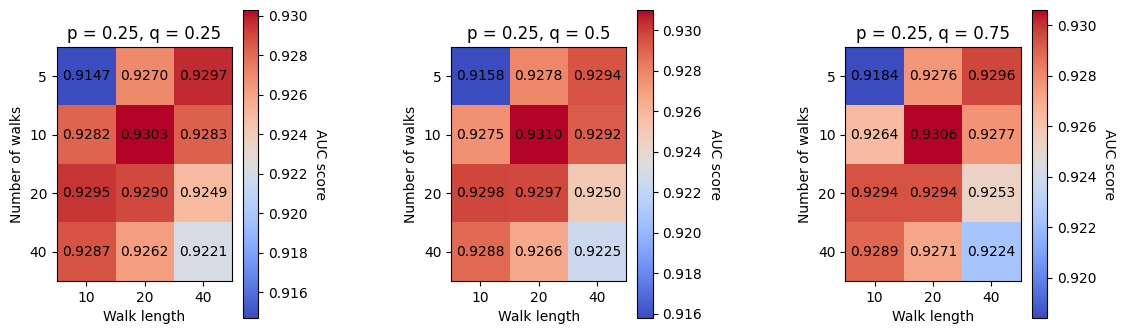

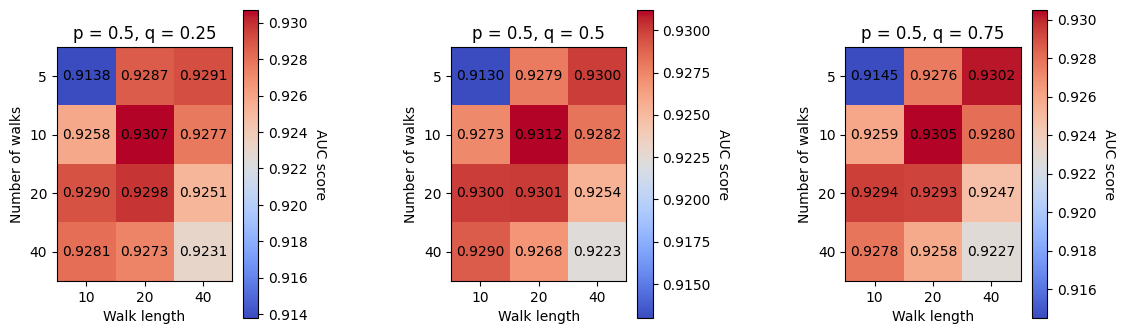

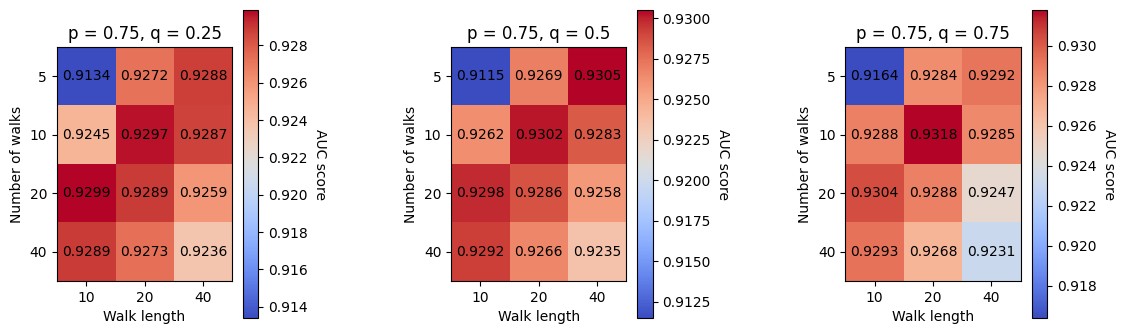

In [10]:
for i in range(len(p_values)):
    corr_heatmap(p_values[i], q_values[0], q_values[1], q_values[2])

In [69]:
np.random.seed(0)

node_dim = 10 # TODO
num_walks = 10 # TODO
walk_length = 20 # TODO
p_list = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95] # TODO
q_list = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95] # TODO

node2vec_auc_scores = dict()
for p in p_list:
    for q in q_list:
        print("node dim: %d,\tnum_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (
                    node_dim, num_walks, walk_length, p, q), end="\n")
        alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
        model = build_node2vec(graph, alias_nodes, alias_edges, 
                        node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q,'valid')] = get_auc_score(model, valid_edges, false_edges)
        print("valid auc: %.4f" % (node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q,'valid')]))

node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.05,	q: 0.05


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9569	training time: 75.6839
valid auc: 0.9304
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.05,	q: 0.15


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9684	training time: 76.4103
valid auc: 0.9299
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.05,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9693	training time: 50.7258
valid auc: 0.9309
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.05,	q: 0.35


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9710	training time: 35.4330
valid auc: 0.9289
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.05,	q: 0.45


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9711	training time: 36.4172
valid auc: 0.9289
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.05,	q: 0.55


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9730	training time: 34.2187
valid auc: 0.9305
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.05,	q: 0.65


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9731	training time: 33.4513
valid auc: 0.9296
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.05,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9736	training time: 35.8999
valid auc: 0.9289
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.05,	q: 0.85


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9758	training time: 35.7109
valid auc: 0.9282
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.05,	q: 0.95


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9754	training time: 35.8393
valid auc: 0.9276
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.15,	q: 0.05


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9413	training time: 43.3284
valid auc: 0.9284
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.15,	q: 0.15


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9643	training time: 37.1431
valid auc: 0.9303
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.15,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9659	training time: 44.3275
valid auc: 0.9296
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.15,	q: 0.35


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9641	training time: 58.1009
valid auc: 0.9307
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.15,	q: 0.45


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9671	training time: 45.0715
valid auc: 0.9308
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.15,	q: 0.55


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9668	training time: 46.8781
valid auc: 0.9307
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.15,	q: 0.65


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9702	training time: 43.5321
valid auc: 0.9307
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.15,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9717	training time: 43.2732
valid auc: 0.9301
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.15,	q: 0.85


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9686	training time: 39.7474
valid auc: 0.9303
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.15,	q: 0.95


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9699	training time: 39.9172
valid auc: 0.9317
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.25,	q: 0.05


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9259	training time: 47.1546
valid auc: 0.9294
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.25,	q: 0.15


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9534	training time: 42.9572
valid auc: 0.9301
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.25,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9599	training time: 47.6814
valid auc: 0.9317
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.25,	q: 0.35


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9687	training time: 43.7845
valid auc: 0.9317
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.25,	q: 0.45


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9660	training time: 43.0868
valid auc: 0.9312
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.25,	q: 0.55


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9694	training time: 41.7497
valid auc: 0.9309
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.25,	q: 0.65


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9702	training time: 48.9231
valid auc: 0.9314
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.25,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9685	training time: 39.9052
valid auc: 0.9309
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.25,	q: 0.85


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9698	training time: 37.6210
valid auc: 0.9316
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.25,	q: 0.95


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9678	training time: 41.4525
valid auc: 0.9310
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.35,	q: 0.05


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9210	training time: 47.5300
valid auc: 0.9304
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.35,	q: 0.15


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9482	training time: 44.7814
valid auc: 0.9297
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.35,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9535	training time: 44.6112
valid auc: 0.9306
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.35,	q: 0.35


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9618	training time: 45.2943
valid auc: 0.9299
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.35,	q: 0.45


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9620	training time: 43.0990
valid auc: 0.9293
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.35,	q: 0.55


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9656	training time: 44.2069
valid auc: 0.9310
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.35,	q: 0.65


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9676	training time: 66.9816
valid auc: 0.9316
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.35,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9680	training time: 60.7681
valid auc: 0.9304
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.35,	q: 0.85


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9702	training time: 67.2508
valid auc: 0.9315
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.35,	q: 0.95


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9715	training time: 68.0372
valid auc: 0.9305
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.45,	q: 0.05


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9115	training time: 63.6805
valid auc: 0.9298
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.45,	q: 0.15


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9415	training time: 62.2917
valid auc: 0.9299
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.45,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9496	training time: 48.0361
valid auc: 0.9303
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.45,	q: 0.35


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9594	training time: 49.9695
valid auc: 0.9300
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.45,	q: 0.45


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9610	training time: 65.0607
valid auc: 0.9308
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.45,	q: 0.55


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9606	training time: 62.5442
valid auc: 0.9306
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.45,	q: 0.65


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9663	training time: 60.3106
valid auc: 0.9309
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.45,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9651	training time: 68.1214
valid auc: 0.9309
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.45,	q: 0.85


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9671	training time: 67.4951
valid auc: 0.9315
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.45,	q: 0.95


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9663	training time: 58.9486
valid auc: 0.9316
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.55,	q: 0.05


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9050	training time: 61.8733
valid auc: 0.9294
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.55,	q: 0.15


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9332	training time: 57.7795
valid auc: 0.9309
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.55,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9426	training time: 58.0066
valid auc: 0.9301
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.55,	q: 0.35


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9522	training time: 47.4187
valid auc: 0.9298
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.55,	q: 0.45


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9604	training time: 42.4332
valid auc: 0.9315
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.55,	q: 0.55


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9634	training time: 45.4754
valid auc: 0.9318
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.55,	q: 0.65


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9652	training time: 53.1086
valid auc: 0.9303
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.55,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9602	training time: 61.2323
valid auc: 0.9316
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.55,	q: 0.85


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9639	training time: 58.1989
valid auc: 0.9309
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.55,	q: 0.95


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9660	training time: 59.6866
valid auc: 0.9317
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.65,	q: 0.05


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9036	training time: 58.2067
valid auc: 0.9297
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.65,	q: 0.15


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9330	training time: 58.8368
valid auc: 0.9297
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.65,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9441	training time: 60.0194
valid auc: 0.9303
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.65,	q: 0.35


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9536	training time: 57.2386
valid auc: 0.9299
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.65,	q: 0.45


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9595	training time: 58.3404
valid auc: 0.9304
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.65,	q: 0.55


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9608	training time: 58.9356
valid auc: 0.9307
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.65,	q: 0.65


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9632	training time: 58.3931
valid auc: 0.9304
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.65,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9650	training time: 56.3007
valid auc: 0.9309
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.65,	q: 0.85


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9665	training time: 53.4685
valid auc: 0.9302
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.65,	q: 0.95


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9662	training time: 45.1335
valid auc: 0.9305
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.75,	q: 0.05


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.8973	training time: 54.3009
valid auc: 0.9306
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.75,	q: 0.15


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9288	training time: 62.0974
valid auc: 0.9312
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.75,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9431	training time: 68.4471
valid auc: 0.9299
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.75,	q: 0.35


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9440	training time: 66.5737
valid auc: 0.9301
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.75,	q: 0.45


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9531	training time: 59.0750
valid auc: 0.9307
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.75,	q: 0.55


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9589	training time: 64.8363
valid auc: 0.9305
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.75,	q: 0.65


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9605	training time: 69.6617
valid auc: 0.9305
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.75,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9634	training time: 57.8018
valid auc: 0.9317
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.75,	q: 0.85


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9628	training time: 57.5367
valid auc: 0.9305
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.75,	q: 0.95


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9679	training time: 46.3953
valid auc: 0.9316
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.85,	q: 0.05


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.8989	training time: 46.3298
valid auc: 0.9298
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.85,	q: 0.15


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9236	training time: 45.4776
valid auc: 0.9310
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.85,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9392	training time: 49.2406
valid auc: 0.9299
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.85,	q: 0.35


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9438	training time: 53.3558
valid auc: 0.9298
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.85,	q: 0.45


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9553	training time: 57.3181
valid auc: 0.9304
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.85,	q: 0.55


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9557	training time: 59.3612
valid auc: 0.9317
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.85,	q: 0.65


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9588	training time: 49.9173
valid auc: 0.9306
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.85,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9645	training time: 57.7634
valid auc: 0.9317
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.85,	q: 0.85


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9601	training time: 54.6960
valid auc: 0.9304
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.85,	q: 0.95


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9643	training time: 46.6292
valid auc: 0.9307
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.95,	q: 0.05


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.8996	training time: 50.5745
valid auc: 0.9292
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.95,	q: 0.15


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9182	training time: 71.7120
valid auc: 0.9300
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.95,	q: 0.25


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9350	training time: 72.2884
valid auc: 0.9305
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.95,	q: 0.35


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9429	training time: 67.1691
valid auc: 0.9303
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.95,	q: 0.45


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9496	training time: 66.0640
valid auc: 0.9312
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.95,	q: 0.55


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9529	training time: 73.6059
valid auc: 0.9310
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.95,	q: 0.65


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9564	training time: 66.2624
valid auc: 0.9310
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.95,	q: 0.75


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9601	training time: 61.9368
valid auc: 0.9310
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.95,	q: 0.85


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9609	training time: 44.9421
valid auc: 0.9312
node dim: 10,	num_walks: 10,	walk_length: 20,	p: 0.95,	q: 0.95


C:\Users\SANGIN_HA\AppData\Local\Temp\ipykernel_12096\129575388.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  J = np.zeros(K, dtype=np.int)


building a node2vec model...
number of walks: 83340	average walk length: 19.9662	training time: 42.7524
valid auc: 0.9312


In [82]:
num_walks = 10
walk_length =20
p_list = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95] # TODO
q_list = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95] # TODO
def corr_heatmap2():
    # Create figure and axes objects
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 10))
    # Create heatmap 1
    a1 = np.array([node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q, 'valid')] for p in p_list for q in q_list])
    a1 = a1.reshape(10, 10)
    im1 = ax1.imshow(a1, cmap="coolwarm", interpolation="nearest")

    # Add colorbars
    cbar1 = ax1.figure.colorbar(im1, ax=ax1)
    cbar1.ax.set_ylabel("AUC score", rotation=-90, va="bottom")

    # Add annotations to heatmap 1
    for i in range(len(q_list)):
        for j in range(len(p_list)):
            text = ax1.text(j, i, "{:.4f}".format(a1[i, j]), ha="center", va="center", color="black")

    # Set axis labels and tick marks for heatmap 1
    ax1.set_yticks(np.arange(len(p_list)))
    ax1.set_xticks(np.arange(len(q_list)))
    ax1.set_yticklabels(p_list)
    ax1.set_xticklabels(q_list)
    ax1.set_xlabel("q value")
    ax1.set_ylabel("p value")

    # Rotate tick labels on y-axis
    plt.setp(ax1.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")

    # Show plot
    plt.show()

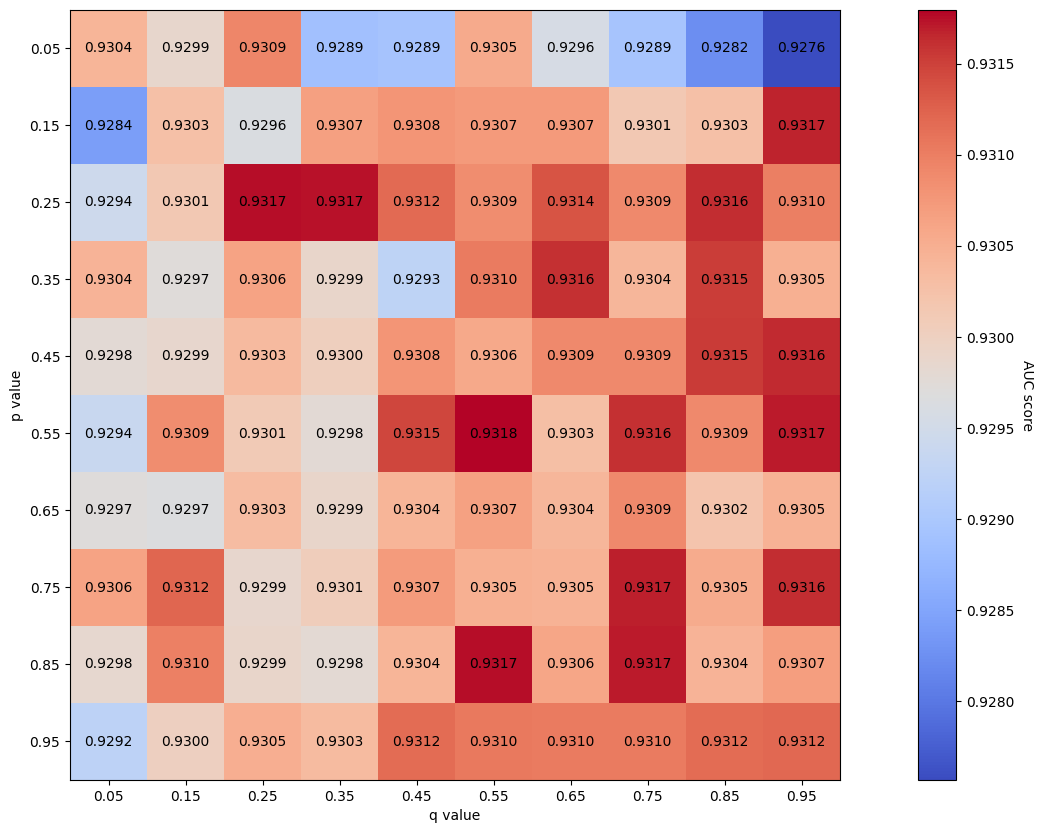

In [83]:
corr_heatmap2()

You can build model with the best parameters you find and save the prediction here.

In [84]:
model = build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=25, walk_length=15)
scores = [get_cosine_sim(model, src, dst) for src, dst in test_edges]
write_pred("data/pred.csv", test_edges, scores)

building a DeepWalk model...
number of walks: 208350	average walk length: 14.8359	training time: 65.3953


With the help of p and q, the node2vec model can fit training data better. And you can have a try if you set p=q=1, the two models will return the same results.